In [1]:
import os
import numpy as np
import h5py
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_lightning import LightningModule
from sklearn.model_selection import train_test_split

In [2]:
# Path setup
model_path = "best_model_v9-epoch=2861-val_loss=0.00467417.ckpt"  
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'
save_dir = r'C:\Users\kiena\Python Project\Year4Project\dev\GarstecModel_V9' 
os.makedirs(save_dir, exist_ok=True)

In [3]:
class GarstecNet(LightningModule):
    def __init__(self, input_dim, output_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),  # First layer maps input_dim to 256 neurons
            nn.ReLU(),
            nn.Linear(256, 128),  # 2
            nn.ReLU(),
            nn.Linear(128, 64),  # 3
            nn.ReLU(),
            nn.Linear(64, 32),  # 4
            nn.ReLU(),
            nn.Linear(32, 32),  # 5
            nn.ReLU(),
            nn.Linear(32, output_dim)  # Output layer
        )
        self.criterion = nn.MSELoss()
        self.lr=lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=15, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            },
        }

In [4]:
def load_data():
    # 7 Inputs
    ages = []
    massini = []
    fehini = []
    alphamlt = []
    yini = []
    eta = []
    alphafe = []

    # 5 Outputs
    teff = []
    luminosity = []
    dnufit = []
    FeH = []
    numax = []

    # Open the hdf5 file
    with h5py.File(garstec_data, 'r') as hdf:
        grid = hdf['grid']
        tracks = grid['tracks']

        # Get track names and shuffle
        track_names = list(tracks.keys())
        random.seed(1)  # Use same seed as in training
        random.shuffle(track_names)

        # Choose a subset of tracks
        selected_tracks = track_names[:]

        for track_name in selected_tracks:
            track = tracks[track_name]
            # Inputs
            ages.append(track['age'][:])
            massini.append(track['massini'][:])
            fehini.append(track['FeHini'][:])
            alphamlt.append(track['alphaMLT'][:])
            yini.append(track['yini'][:])
            eta.append(track['eta'][:])
            alphafe.append(track['alphaFe'][:])

            # Outputs
            teff.append(track['Teff'][:])
            luminosity.append(track['LPhot'][:])
            dnufit.append(track['dnufit'][:])
            FeH.append(track['FeH'][:])
            numax.append(track['numax'][:])

        # Track which points belong to which tracks
        track_indices = []
        for i, track_name in enumerate(selected_tracks):
            track = tracks[track_name]
            # Add the track index for each point in this track
            track_indices.extend([i] * len(track['Teff'][:]))
    
    track_indices = np.array(track_indices)

    # Convert to numpy arrays and apply transformations
    epsilon = 1e-10
    
    # Transform inputs
    log10_vars_inputs = [ages, massini, alphamlt, eta, yini]
    log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]
    inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), 
                                                  np.concatenate(alphafe).reshape(-1, 1)])
    
    # Transform outputs
    log10_vars_outputs = [teff, luminosity, dnufit, numax]
    log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]
    outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1)])
    
    # Create a list of output parameter names for plotting
    output_names = ['log T_eff', 'log L', 'log dnu', 'log numax', 'FeH']
    
    return inputs, outputs, output_names, track_indices




In [5]:
# Calculate residuals without scaler!

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Load data
inputs, outputs, output_names, track_indices = load_data()
    
# Split data with same random state as in training
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)


# Load the trained model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
    
# Load model with map_location to handle device differences
model = GarstecNet.load_from_checkpoint(
    model_path, 
    input_dim=input_dim, 
    output_dim=output_dim,
    map_location=device
)
model.eval()  # Set to evaluation mode
model.to(device)  # Ensure model is on the correct device
    
# Make predictions on test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()  # Move predictions back to CPU before converting to numpy
    

# Calculate residuals
log_residuals = y_pred - y_test

# Convert predictions and test values from log to linear scale
# For the first 4 outputs (teff, luminosity, dnufit, numax) which were log-transformed
normal_pred = np.copy(y_pred)
normal_test = np.copy(y_test)

# Convert log outputs back to linear scale
for i in range(4):  # First 4 columns were log-transformed
    normal_pred[:, i] = 10**normal_pred[:, i]
    normal_test[:, i] = 10**normal_test[:, i]
# Note: FeH (index 4) was not log-transformed, so we leave it as is

# Calculate normal residuals
normal_residuals = normal_pred - normal_test


Using device: cuda


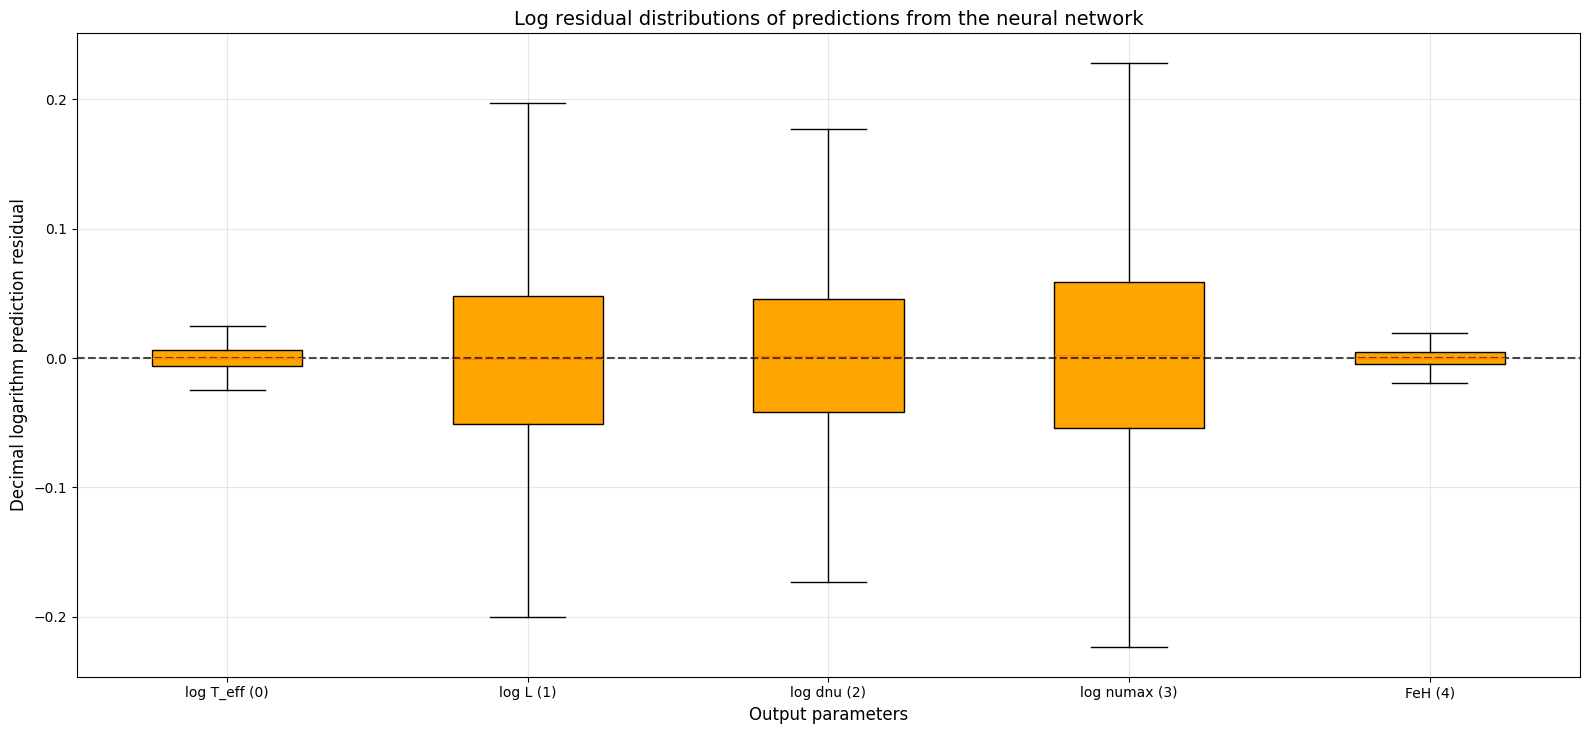

In [6]:
def log_residual_plots():
    
    plt.figure(figsize=(16, 8))
    
    # Prepare x-axis labels with indices
    x_labels = [f'{name} ({i})' for i, name in enumerate(output_names)]
    
    # Create boxplot
    boxplot = plt.boxplot(log_residuals, patch_artist=True, tick_labels=x_labels, showfliers=False)
    
    # Customize boxplot colors
    for box in boxplot['boxes']:
        box.set(facecolor='orange')  # Orange color similar to the reference image
    
    # Add horizontal line at y=0
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.title('Log residual distributions of predictions from the neural network', fontsize=14)
    plt.xlabel('Output parameters', fontsize=12)
    plt.ylabel('Decimal logarithm prediction residual', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for the figtext
    plt.show()
    

log_residual_plots()

In [7]:
def log_residual_stats():
    # Calculate and print statistics for each output parameter
    print("\nResidual Statistics:")
    print("====================")
    
    for i, name in enumerate(output_names):
        param_residuals = log_residuals[:, i]
        stats = {
            'Mean': np.mean(param_residuals),
            'Std Dev': np.std(param_residuals),
            '5th Percentile': np.percentile(param_residuals, 5),
            '25th Percentile': np.percentile(param_residuals, 25),
            'Median': np.median(param_residuals),
            '75th Percentile': np.percentile(param_residuals, 75),
            '95th Percentile': np.percentile(param_residuals, 95),
            'Min': np.min(param_residuals),
            'Max': np.max(param_residuals)
        }
        
        print(f"\n{name} (Parameter {i}):")
        for stat_name, value in stats.items():
            print(f"  {stat_name}: {value:.6f}")

log_residual_stats()


Residual Statistics:

log T_eff (Parameter 0):
  Mean: 0.000158
  Std Dev: 0.010944
  5th Percentile: -0.015950
  25th Percentile: -0.006046
  Median: 0.000199
  75th Percentile: 0.006409
  95th Percentile: 0.016162
  Min: -0.195408
  Max: 0.104494

log L (Parameter 1):
  Mean: -0.003100
  Std Dev: 0.085896
  5th Percentile: -0.145650
  25th Percentile: -0.051103
  Median: -0.000925
  75th Percentile: 0.048266
  95th Percentile: 0.131809
  Min: -0.621667
  Max: 0.538627

log dnu (Parameter 2):
  Mean: 0.002823
  Std Dev: 0.076626
  5th Percentile: -0.119754
  25th Percentile: -0.041879
  Median: 0.001928
  75th Percentile: 0.045802
  95th Percentile: 0.129201
  Min: -0.470169
  Max: 0.537664

log numax (Parameter 3):
  Mean: 0.003650
  Std Dev: 0.099547
  5th Percentile: -0.155779
  25th Percentile: -0.054121
  Median: 0.002347
  75th Percentile: 0.058935
  95th Percentile: 0.168472
  Min: -0.614364
  Max: 0.699584

FeH (Parameter 4):
  Mean: 0.000098
  Std Dev: 0.009356
  5th Percent

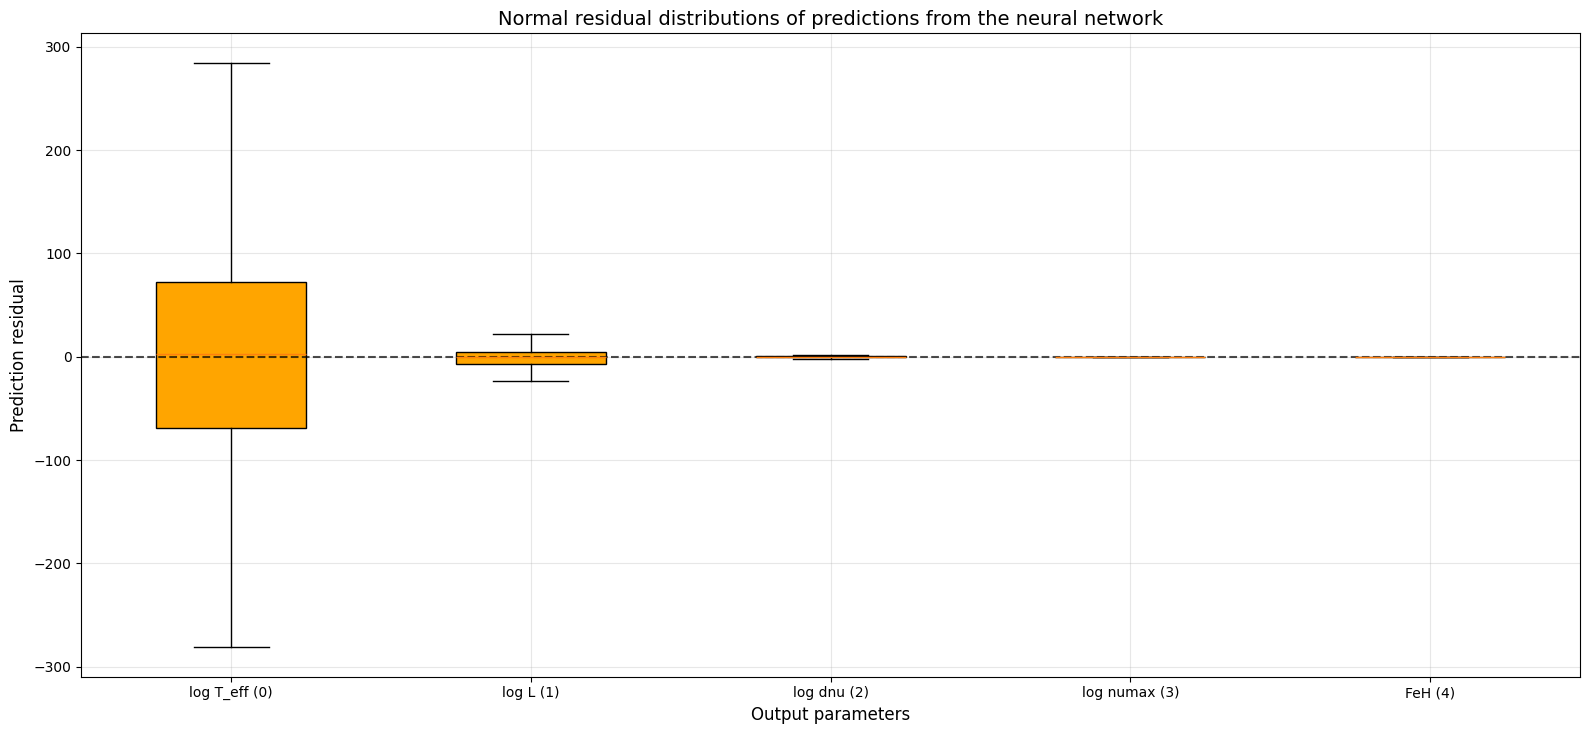

In [8]:
def normal_residual_plots():
    
    plt.figure(figsize=(16, 8))
    
    # Prepare x-axis labels with indices
    x_labels = [f'{name} ({i})' for i, name in enumerate(output_names)]
    
    # Create boxplot
    boxplot = plt.boxplot(normal_residuals, patch_artist=True, tick_labels=x_labels, showfliers=False)
    
    # Customize boxplot colors
    for box in boxplot['boxes']:
        box.set(facecolor='orange')  # Orange color similar to the reference image
    
    # Add horizontal line at y=0
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Customize plot
    plt.title('Normal residual distributions of predictions from the neural network', fontsize=14)
    plt.xlabel('Output parameters', fontsize=12)
    plt.ylabel('Prediction residual', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Adjust for the figtext
    plt.show()
    

normal_residual_plots()

In [9]:
def calculate_parameter_medians(original_test, original_pred):
    # Convert log values back to linear scale for the first 4 parameters
    normal_test = np.copy(original_test)
    for i in range(4):  # teff, luminosity, dnu, numax
        normal_test[:, i] = 10**normal_test[:, i]
    
    # Define parameter names
    param_names = ["Teff (K)", "Luminosity (L☉)", "Δν (μHz)", "ν_max (μHz)", "[Fe/H] (dex)"]
    
    # Calculate median for each parameter
    medians = np.median(normal_test, axis=0)
    
    # Print results in a formatted table
    print("Parameter Median Values from Dataset:")
    print("-" * 40)
    for name, median in zip(param_names, medians):
        if name == "[Fe/H] (dex)":
            print(f"{name:<20} {median:.3f}")
        else:
            print(f"{name:<20} {median:.2f}")
    
    return medians

# Call the function
median_values = calculate_parameter_medians(y_test_original, y_pred_original)

NameError: name 'y_test_original' is not defined

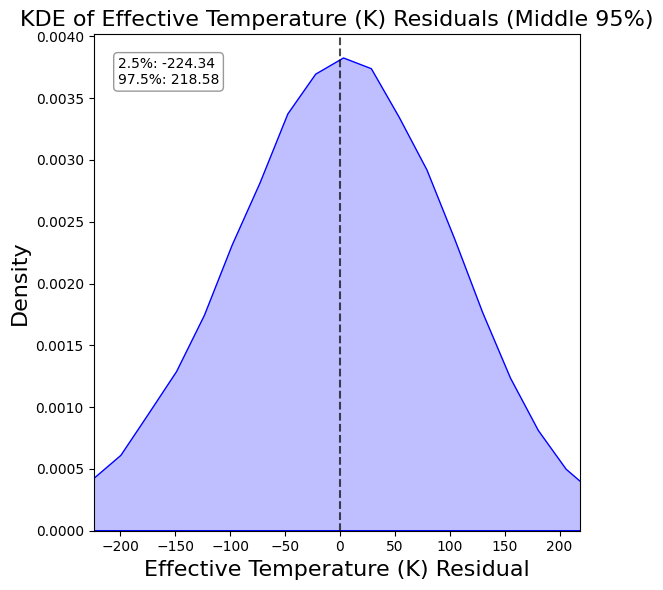

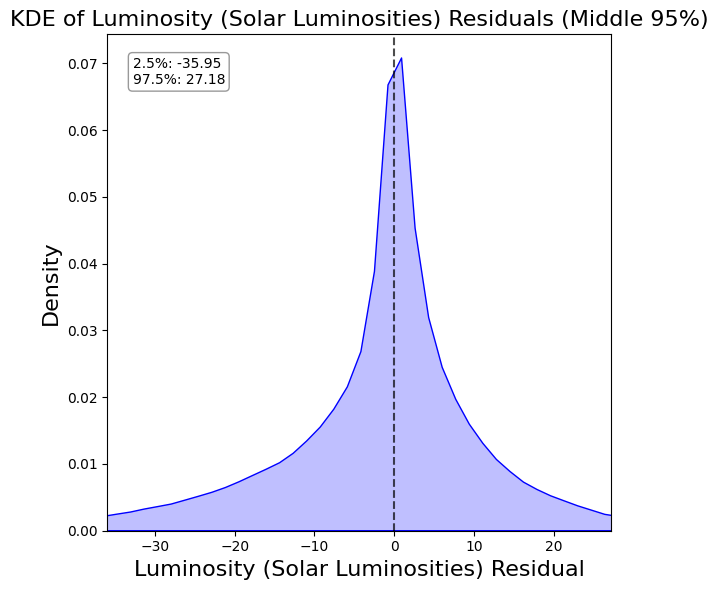

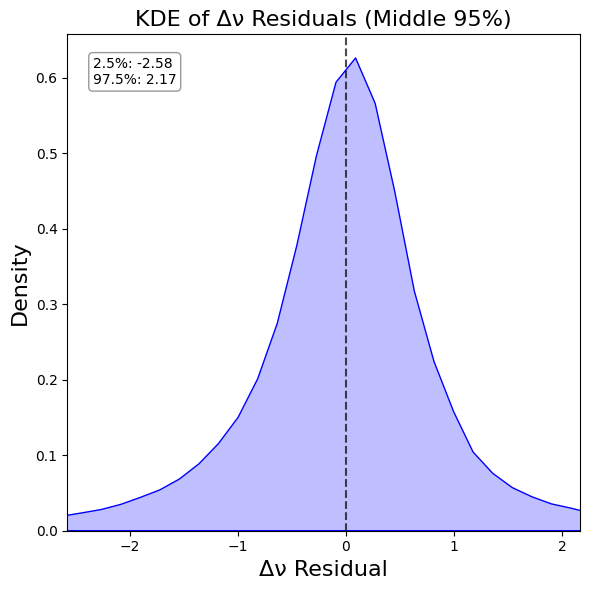

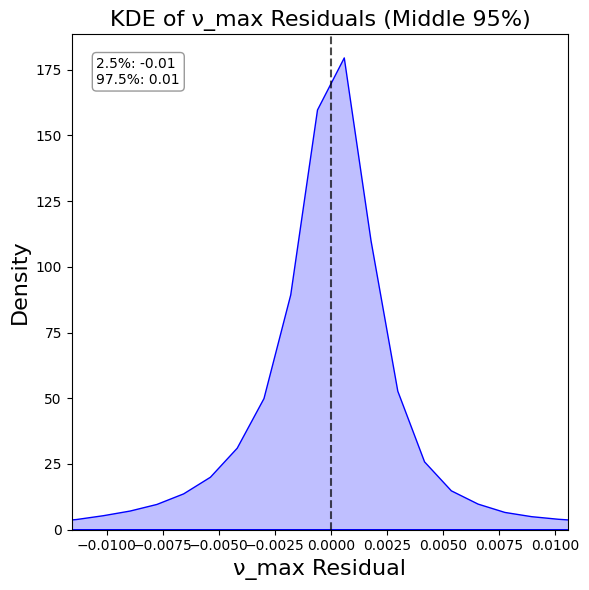

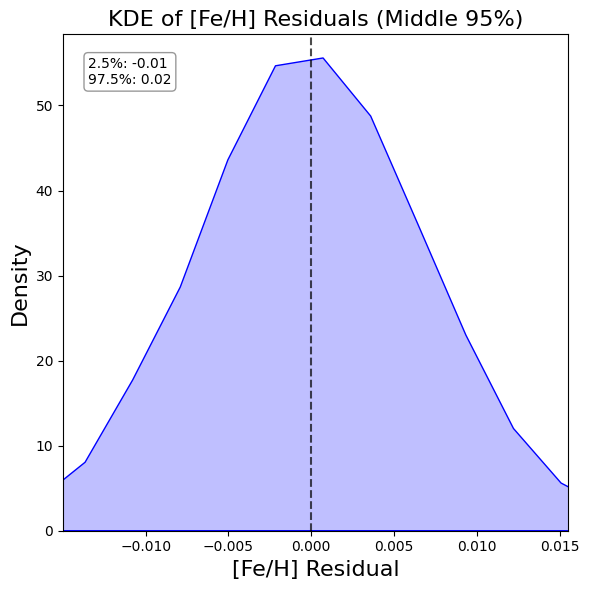

In [10]:
def individual_kde_plots():
    # Define parameter names for each column of normal_residuals
    names = ["Effective Temperature (K)", "Luminosity (Solar Luminosities)", "Δν", "ν_max", "[Fe/H]"]
    
    # Iterate through each parameter
    for i, name in enumerate(names):
        # Extract residuals for current parameter
        residual = normal_residuals[:, i]
        
        # Calculate the 2.5th and 97.5th percentiles (middle 95%)
        lower_bound = np.percentile(residual, 2.5)
        upper_bound = np.percentile(residual, 97.5)
        
        plt.figure(figsize=(6, 6))
        
        # Create KDE plot
        sns.kdeplot(x=residual, fill=True, color='blue')
        
        # Add reference line at zero
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
        
        # Set x-axis limits to show only middle 95%
        plt.xlim(lower_bound, upper_bound)
        
        # Add title and labels
        plt.title(f'KDE of {name} Residuals (Middle 95%)', fontsize=16)
        plt.xlabel(f'{name} Residual', fontsize=16)
        plt.ylabel('Density', fontsize=16)
        







        
        # Display percentile values in a text box
        plt.annotate(f'2.5%: {lower_bound:.2f}\n97.5%: {upper_bound:.2f}', 
                    xy=(0.05, 0.9), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        plt.tight_layout()
        plt.show()

individual_kde_plots()

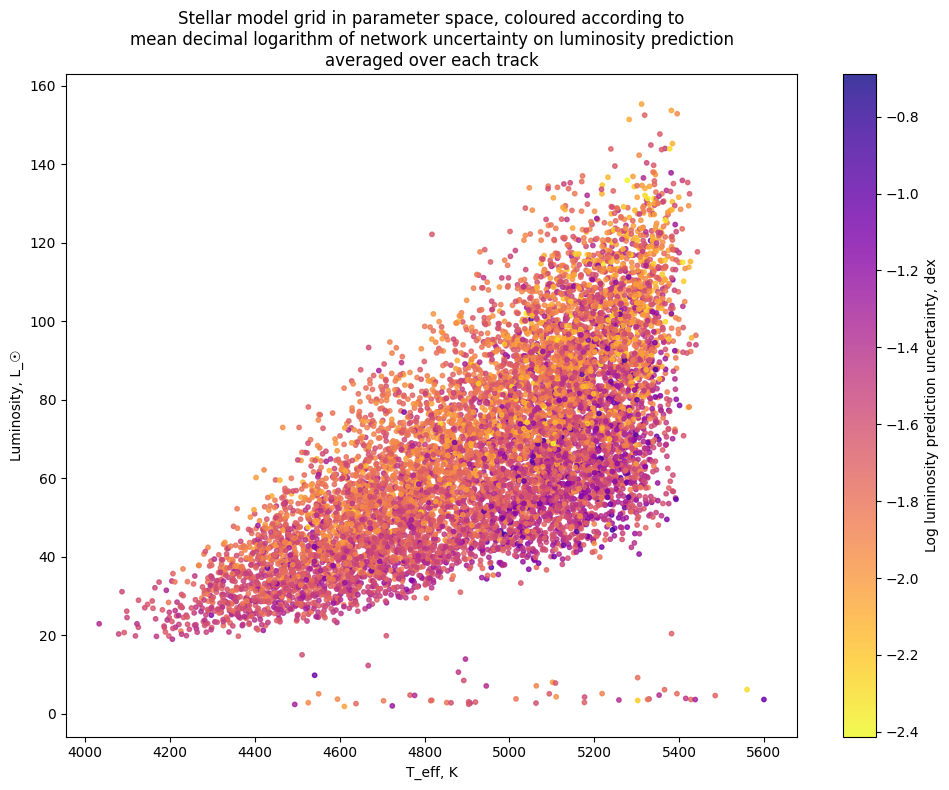

In [ ]:
def plot_model_grid_with_uncertainties():
    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values
    median_teff = []
    median_lum = []
    track_residuals = []
    
    # For each track, calculate the median values and mean residual
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        
        # Calculate residuals for this track (for luminosity)
        track_lum_residuals = log_residuals[indices, 1]  # This is residual in log space
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for this track
        mean_abs_residual = np.mean(np.abs(track_lum_residuals))
        track_residuals.append(mean_abs_residual)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals = np.array(track_residuals)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals + 1e-10),  # Log scale for residuals (add small value to avoid log(0))
        cmap='plasma_r',  
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log luminosity prediction uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on luminosity prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    #if np.max(median_lum)/np.min(median_lum) > 10:
    #   plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties()

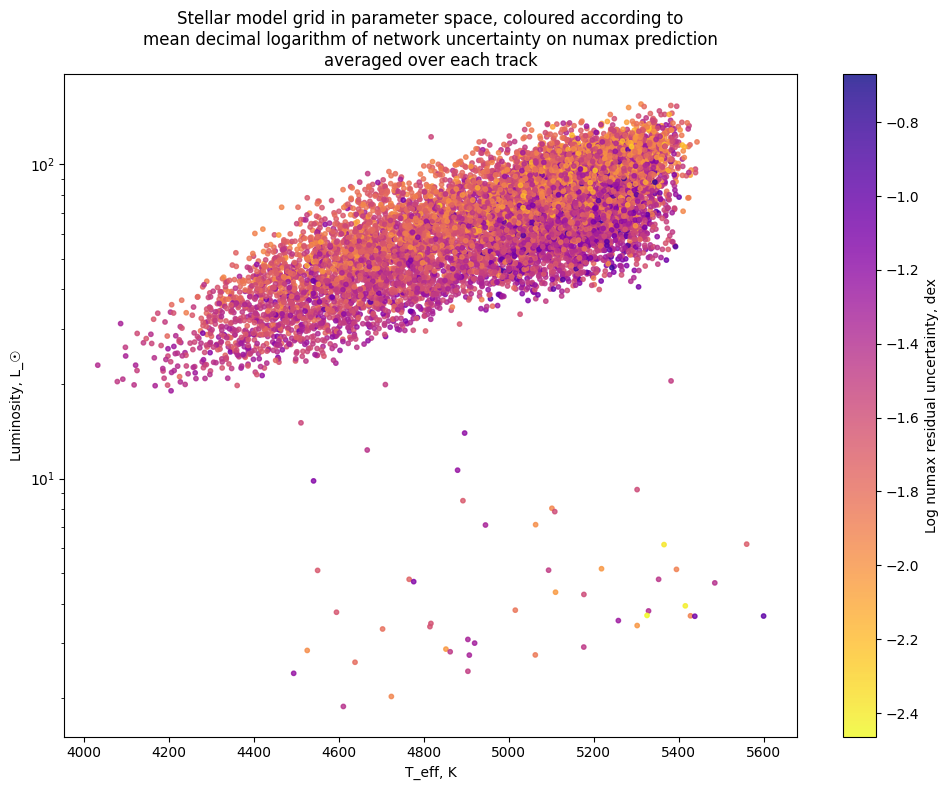

In [ ]:
def plot_model_grid_with_uncertainties_1():

# Same function as above but with colours according to numax residuals

    # First, ensure that track_indices matches the test set
    # We need track indices only for the test set, not the full dataset
    _, test_indices = train_test_split(range(len(inputs)), test_size=0.2, random_state=1)
    test_track_indices = track_indices[test_indices]
    
    # Extract unique tracks in the test set
    unique_tracks = np.unique(test_track_indices)
    
    # Prepare containers for median values and numax residuals
    median_teff = []
    median_lum = []
    track_residuals_numax = []  # Change this to store numax residuals
    
    # For each track, calculate the median values and mean residual for numax
    for track_idx in unique_tracks:
        # Get indices where test_track_indices equals this track
        mask = test_track_indices == track_idx
        indices = np.where(mask)[0]
        
        if len(indices) == 0:
            continue  # Skip if no points for this track in test set
            
        # Get original values and residuals for this track
        track_teff_original = 10**y_test_original[indices, 0]  # Convert from log10 back to linear scale
        track_lum_original = 10**y_test_original[indices, 1]
        track_numax_original = 10**y_test_original[indices, 3]  # Assuming numax is at index 3 in your original output
        
        # Calculate residuals for this track (for numax)
        track_numax_residuals = log_residuals[indices, 3]  # Residuals for numax (in log space)
        
        # Calculate median values for this track
        median_teff.append(np.median(track_teff_original))
        median_lum.append(np.median(track_lum_original))
        
        # Calculate mean absolute residual for numax (at the median point)
        mean_abs_residual_numax = np.mean(np.abs(track_numax_residuals))
        track_residuals_numax.append(mean_abs_residual_numax)
    
    # Convert to arrays
    median_teff = np.array(median_teff)
    median_lum = np.array(median_lum)
    track_residuals_numax = np.array(track_residuals_numax)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        median_teff, 
        median_lum, 
        c=np.log10(track_residuals_numax + 1e-10),  # Log scale for numax residuals (add small value to avoid log(0))
        cmap='plasma_r',
        s=10,  # Marker size
        alpha=0.8
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Log numax residual uncertainty, dex')
    
    # Set axis labels and title
    plt.xlabel('T_eff, K')
    plt.ylabel('Luminosity, L_☉')
    plt.title('Stellar model grid in parameter space, coloured according to\n'
              'mean decimal logarithm of network uncertainty on numax prediction\n'
              'averaged over each track')
    
    # Use log scale if data spans multiple orders of magnitude
    if np.max(median_lum)/np.min(median_lum) > 10:
        plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

plot_model_grid_with_uncertainties_1()
